In [64]:
import argparse
import torch
#from sheaffmtl import run_dig_sheaf_fmtl, run_ana_sheaf_fmtl
from utils import read_vehicle_data, read_school_data, read_har_data, read_gleam_data, count_model_parameters, MultinomialLogisticRegression, LinearRegression, generate_random_adjacency_matrix, cross_entropy_loss_with_l2, mse_loss_with_l2
import torch.nn as nn
import numpy as np
import networkx as nx
from scipy.linalg import hadamard
import matplotlib.pyplot as plt

In [65]:
num_clients = 30
print(f"Number of clients {num_clients}")
#print(f"Number of features {client_train_datasets[0][0][0].shape}")

adjacency_matrix = generate_random_adjacency_matrix(num_clients)
neighbors = [np.nonzero(adjacency_matrix[i])[0].tolist() for i in range(num_clients)]
G = nx.from_numpy_array(adjacency_matrix)

Number of clients 30


In [3]:
def dig_comp_level(G, CG, N, Chi, barP, N0 = 10 ** (-169/10) * 1e-3, b = 64, d = 7850):
    K = CG.shape[0]
    m_array = [int( N / Chi * np.log2(1 + barP * Chi / N0 * min(CG[i,[j for j in G[i]]]))) for i in range(K)]
    m_array = np.ceil(np.maximum(np.minimum(np.array(m_array) / b, d), 1))

    return m_array

In [4]:
num_clients = 30
adjacency_matrix = generate_random_adjacency_matrix(num_clients)
G = nx.from_numpy_array(adjacency_matrix)
neighbors = [np.nonzero(adjacency_matrix[i])[0].tolist() for i in range(num_clients)]
color_dict = {
    0: 'r',    # Red
    1: 'b',    # Blue
    2: 'g',    # Green
    3: 'c',    # Cyan
    4: 'm',    # Magenta
    5: 'y',    # Yellow
    6: 'k',    # Black
    7: 'orange',
    8: 'purple',
    9: 'brown',
    10: 'pink'
}

{0: array([-0.07774002,  0.74553524]), 1: array([-0.46131353, -0.0264155 ]), 2: array([ 0.17791472, -0.56005318]), 3: array([-0.0510369 ,  0.22371506]), 4: array([-0.38317913,  0.66008944]), 5: array([-0.6376279 , -0.80646778]), 6: array([ 0.47672434, -0.19496892]), 7: array([ 1.        , -0.34422293]), 8: array([-0.2820614 , -0.37339717]), 9: array([0.23831982, 0.67618575])}


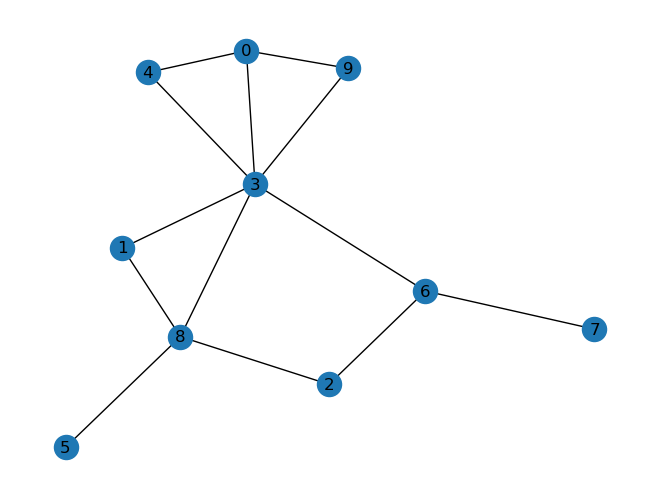

In [5]:
while True:
  G = nx.erdos_renyi_graph(10, 0.3)
  if nx.is_connected(G):
    break
pos = nx.spring_layout(G)
print(pos)
nx.draw(G, pos, with_labels=True)
plt.show()

In [6]:
color_dict = {
    0: 'r',    # Red
    1: 'b',    # Blue
    2: 'g',    # Green
    3: 'c',    # Cyan
    4: 'm',    # Magenta
    5: 'y',    # Yellow
    6: 'k',    # Black
    7: 'orange',
    8: 'purple',
    9: 'brown',
    10: 'pink'
}

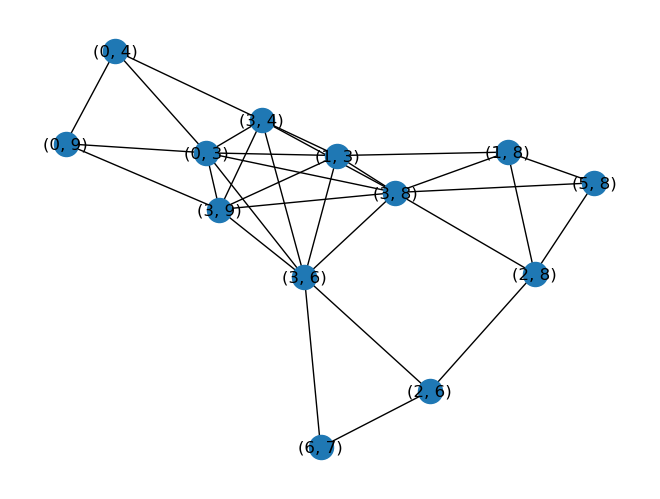

In [7]:
F = nx.line_graph(G)
pos2 = nx.spring_layout(F)
nx.draw(F, pos2, with_labels=True)
plt.show()

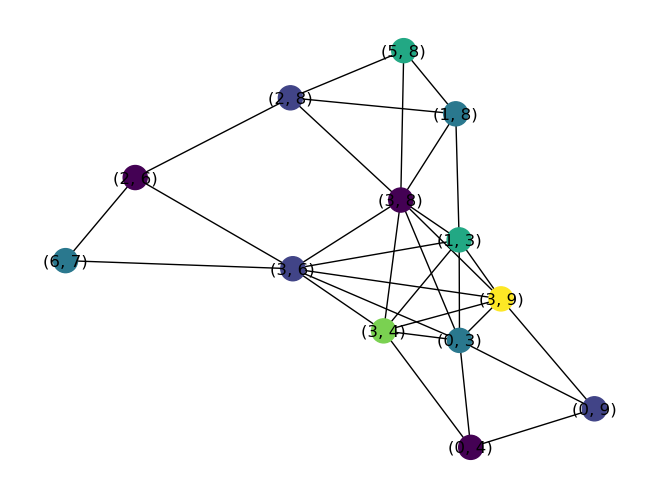

Number of colors needed 6
The maximum degree of the graph is 6


In [8]:
edges_to_colors = nx.coloring.greedy_color(F, strategy="largest_first")
color_map_nodes = []
color_map_edges = []
for node in F:
  color_map_nodes.append(edges_to_colors[node])

for edge in G.edges():
  color_map_edges.append(edges_to_colors[edge])
pos2 = nx.spring_layout(F)
nx.draw(F, pos2, with_labels=True, node_color=color_map_nodes)
plt.show()
max_degree = max(dict(G.degree()).values())
print(f"Number of colors needed {max([x for x in color_map_nodes]) + 1}")
print(f"The maximum degree of the graph is {max_degree}")


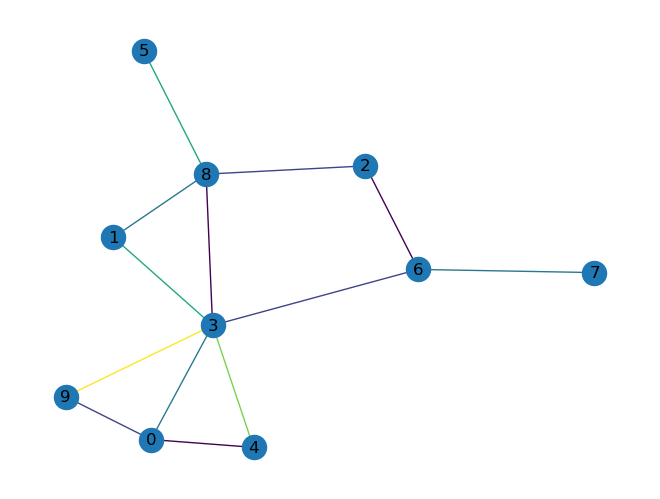

In [9]:
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, edge_color=color_map_edges)
plt.show()

In [10]:
# Group edges by color
edges_by_color = {}
for edge, color in edges_to_colors.items():
    if color not in edges_by_color:
        edges_by_color[color] = []
    edges_by_color[color].append(edge)

# Create and visualize each subgraph for each color
subgraphs = {}
laplacians = {}

for color, edges in edges_by_color.items():
    # Create a new subgraph with all nodes from G but only the selected edges
    subgraph = nx.Graph()
    subgraph.add_nodes_from(G.nodes())  # Add all nodes
    subgraph.add_edges_from(edges)      # Add only edges of this color
    subgraphs[color] = subgraph
    # Calculate the Laplacian matrix for the subgraph
    laplacian_matrix = nx.laplacian_matrix(subgraph).toarray()
    laplacians[color] = laplacian_matrix

# Example to print details
for color, subgraph in subgraphs.items():
    print(f"Subgraph for color {color}:")
    print("Nodes:", subgraph.nodes())
    print("Edges:", subgraph.edges())

Subgraph for color 0:
Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Edges: [(0, 4), (2, 6), (3, 8)]
Subgraph for color 1:
Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Edges: [(0, 9), (2, 8), (3, 6)]
Subgraph for color 2:
Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Edges: [(0, 3), (1, 8), (6, 7)]
Subgraph for color 3:
Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Edges: [(1, 3), (5, 8)]
Subgraph for color 4:
Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Edges: [(3, 4)]
Subgraph for color 5:
Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Edges: [(3, 9)]


In [11]:
import cvxpy as cp
from cvxpy.atoms.lambda_sum_smallest import lambda_sum_smallest

In [12]:
# Given problem parameters
n = len(laplacians)  # Example dimension (replace with actual dimension)

mu = 0.1  # Given parameter mu (adjust as needed)

# Define variables
#lambda_2 = cp.Variable()
x = cp.Variable(n)  # x is a vector with `n` entries

algebraic_connectivity = sum(x[i] * laplacians[i] for i in range(n))

In [13]:
# Define objective
objective = cp.Maximize(lambda_sum_smallest(algebraic_connectivity, 2))

In [14]:

# Define constraints
constraints = [
    x >= 0,          # Elementwise inequality 0 <= x
    cp.sum(x) <= 2, # Elementwise inequality x <= 1
    x <= 1
]

# Formulate and solve the problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Output results
print("Optimal value of lambda_2:", problem.value)
print("Optimal values of x:", x.value)

Optimal value of lambda_2: 0.2062940887607316
Optimal values of x: [0.32763402 0.40785394 0.46701303 0.34952716 0.2311326  0.21683937]


In [15]:
laplacian_matrix = nx.laplacian_matrix(G).toarray()
# Compute eigenvalues
eigenvalues = np.linalg.eigvals(laplacian_matrix)

# Sort eigenvalues in descending order
eigenvalues_sorted = np.sort(eigenvalues)

# Get the second largest eigenvalue
second_smallest_eigenvalue = eigenvalues_sorted[1]
print("Second smallest eigenvalue:", second_smallest_eigenvalue)


Second smallest eigenvalue: 0.553742925698002


In [16]:
'''
import subprocess

# List of experiments with their respective parameters
experiments = [
    {"beta": 0.01, "Ct": 0.1},
    {"beta": 0.01, "Ct": 0.4},
    {"beta": 0.01, "Ct": 0.5},
    {"beta": 0.01, "Ct": 0.9},
    {"beta": 0.1, "Ct": 0.4},
    {"beta": 0.01, "Ct": 0.4},
    {"beta": 0.001, "Ct": 0.4},
]

# Run the experiments
for exp in experiments:
    command = [
        "python", "main.py",
        "--dataset", "school",
        "--algorithm", "Sheaf-FMTL-subgraph",
        "--alpha", "0.005",
        "--eta", "0.05",
        "--lambda-reg", "0.02",
        "--factor", "0.8",
        "--num-rounds", "200",
        "--times", "5",
        "--beta", str(exp["beta"]),
        "--Ct", str(exp["Ct"]),
    ]

    # Run the command and capture the output
    result = subprocess.run(command, capture_output=True, text=True)

    # Print results
    if result.returncode == 0:
        print(f"Experiment with beta={exp['beta']} and Ct={exp['Ct']} completed successfully.")
        print(result.stdout)
    else:
        print(f"Experiment with beta={exp['beta']} and Ct={exp['Ct']} failed.")
        print(result.stderr)

        '''

'\nimport subprocess\n\n# List of experiments with their respective parameters\nexperiments = [\n    {"beta": 0.01, "Ct": 0.1},\n    {"beta": 0.01, "Ct": 0.4},\n    {"beta": 0.01, "Ct": 0.5},\n    {"beta": 0.01, "Ct": 0.9},\n    {"beta": 0.1, "Ct": 0.4},\n    {"beta": 0.01, "Ct": 0.4},\n    {"beta": 0.001, "Ct": 0.4},\n]\n\n# Run the experiments\nfor exp in experiments:\n    command = [\n        "python", "main.py",\n        "--dataset", "school",\n        "--algorithm", "Sheaf-FMTL-subgraph",\n        "--alpha", "0.005",\n        "--eta", "0.05",\n        "--lambda-reg", "0.02",\n        "--factor", "0.8",\n        "--num-rounds", "200",\n        "--times", "5",\n        "--beta", str(exp["beta"]),\n        "--Ct", str(exp["Ct"]),\n    ]\n\n    # Run the command and capture the output\n    result = subprocess.run(command, capture_output=True, text=True)\n\n    # Print results\n    if result.returncode == 0:\n        print(f"Experiment with beta={exp[\'beta\']} and Ct={exp[\'Ct\']} com

In [46]:
import numpy as np

# Example matrices
N = 6  # Number of clients
L = np.real(np.random.randn(N, N) + 1j * np.random.randn(N, N))

L = L * np.conjugate(L)

# Initialize W as an N x N matrix of zeros
W = np.zeros((N, N), dtype=int)

# Set entries of W according to the rules
for i in range(N):
    # Find the column index j that maximizes L[i, j], excluding the diagonal entry (i == j)
    max_j = np.argmax(L[i] * (1 - np.eye(N)[i]))  # Multiply by 0 on the diagonal
    
    # Set W[i, j] = 1 for the max entry
    W[i, max_j] = 1



print("Matrix L:")
print(L)
print("\nMatrix W:")
print(W)

W = W.T

Matrix L:
[[2.16294651e-01 1.67780152e+00 1.30710845e+00 6.07843240e-01
  2.44309413e-01 1.26099324e+00]
 [3.26114010e-03 1.45728782e-02 2.10102221e-01 1.01749990e+00
  4.23415688e-01 3.30109641e-01]
 [9.87997792e-01 5.34122556e+00 9.45489332e-01 1.22835827e-01
  3.76941741e-03 2.94732979e+00]
 [9.47709083e-01 1.61979462e-05 7.73713108e-01 6.55713994e-02
  4.70988962e-01 1.21757381e+00]
 [3.07195018e-01 8.91040142e-04 2.39292142e-01 1.23461320e+00
  1.62671577e-03 2.98106687e+00]
 [2.22040121e+00 1.42932628e-01 6.32240663e-02 1.02964225e+00
  1.61417702e-01 1.92057540e+00]]

Matrix W:
[[0 1 0 0 0 0]
 [0 0 0 1 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [1 0 0 0 0 0]]


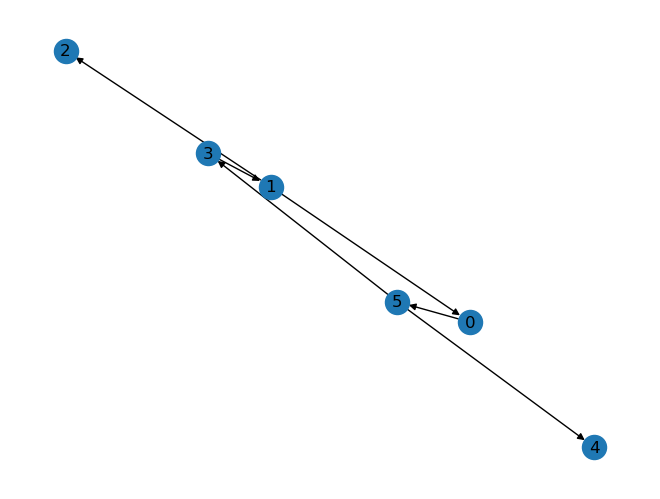

In [47]:
G = nx.DiGraph(W)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
plt.show()

Edges in the directed graph:
[(0, 3), (2, 1), (3, 0), (3, 2)]


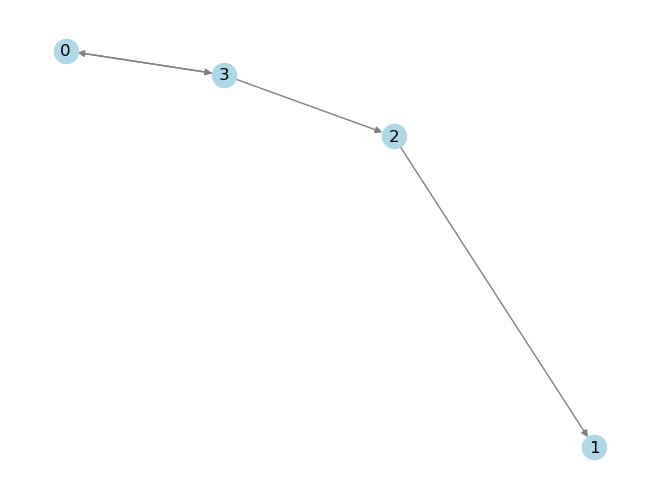

In [38]:
# Create a directed graph from the adjacency matrix
G = nx.from_numpy_array(W, create_using=nx.DiGraph)

# Display the directed graph
print("Edges in the directed graph:")
print(list(G.edges))

# Visualize the graph
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', arrows=True)
plt.show()

In [34]:
for i in G.predecessors(3):
    print(i)

0


Adjacency Matrix:
[[0 1 1 0 1]
 [1 0 1 1 1]
 [1 0 0 1 0]
 [0 0 0 0 1]
 [0 1 1 0 0]]

Neighbors for each client:
Client 0: [1, 2, 4]
Client 1: [0, 2, 3, 4]
Client 2: [0, 3]
Client 3: [4]
Client 4: [1, 2]

Transmitted bits per iteration (cumulative):
[768000, 1536000, 2304000, 3072000, 3840000, 4608000, 5376000, 6144000, 6912000, 7680000]


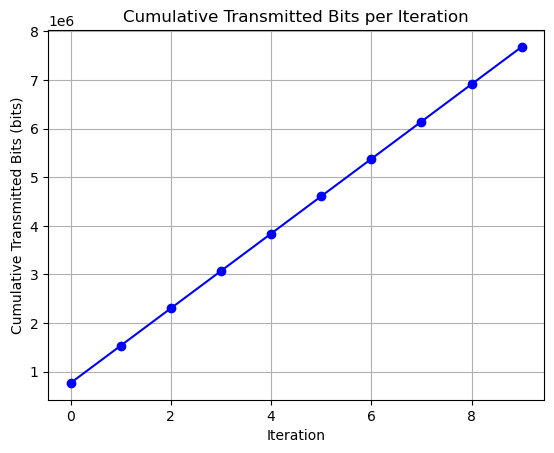

In [48]:
# Example Parameters
num_params = 1000  # Assume 1000 parameters in the model
factor = 1  # Scaling factor
num_clients = 5  # Let's assume we have 5 clients

# Create a random adjacency matrix (graph) for 5 clients
# This will represent a network where 1 means clients are neighbors, and 0 means not.
np.random.seed(0)  # For reproducibility
merged_adjacency_matrix = np.random.randint(0, 2, size=(num_clients, num_clients))
np.fill_diagonal(merged_adjacency_matrix, 0)  # Clients are not neighbors with themselves

# Count the number of neighbors for each client
neighbors = [np.nonzero(merged_adjacency_matrix[i])[0].tolist() for i in range(num_clients)]
max_neighbors = max(len(n) for n in neighbors)

# Calculate communication cost
cumulative_transmitted_bits = 0
transmitted_bits_per_iteration = []

# Simulate for 10 rounds (iterations)
for round in range(10):
    cumulative_transmitted_bits += sum(2 * len(neighbors[i]) * 32 * int(factor * num_params) for i in range(num_clients))
    transmitted_bits_per_iteration.append(cumulative_transmitted_bits)

# Print the adjacency matrix and neighbors for each client
print("Adjacency Matrix:")
print(merged_adjacency_matrix)

print("\nNeighbors for each client:")
for i, n in enumerate(neighbors):
    print(f"Client {i}: {n}")

print("\nTransmitted bits per iteration (cumulative):")
print(transmitted_bits_per_iteration)

# Plot the transmitted bits per iteration
plt.plot(transmitted_bits_per_iteration, marker='o', linestyle='-', color='b')
plt.title("Cumulative Transmitted Bits per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Cumulative Transmitted Bits (bits)")
plt.grid(True)
plt.show()

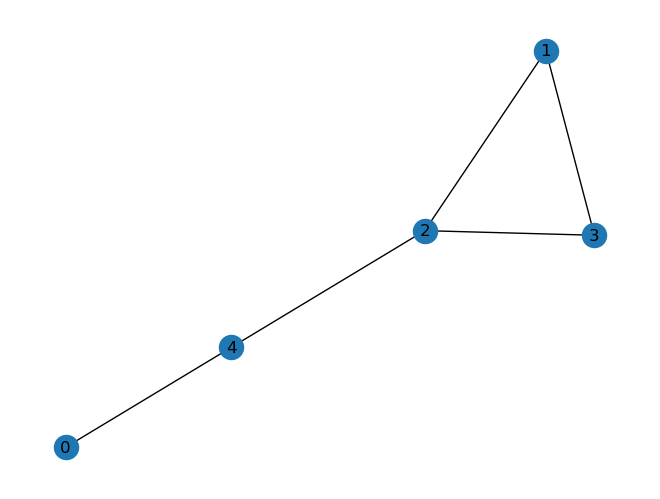

In [85]:
# Generate a random symmetric adjacency matrix for an undirected (bidirectional) graph
num_nodes = 5  # Example graph with 5 nodes
adj_matrix = np.random.randint(0, 2, size=(num_nodes, num_nodes))  # Random binary matrix
np.fill_diagonal(adj_matrix, 0)  # No self-loops

# Make the graph symmetric to ensure it's undirected (bidirectional)
adj_matrix = np.triu(adj_matrix) + np.triu(adj_matrix, 1).T

G = nx.from_numpy_array(adj_matrix)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
plt.show()

In [86]:
0.5 * np.sum(adj_matrix)

5.0

Generated Bidirectional Graph (Adjacency Matrix):
[[0 1 0 1 0]
 [1 0 1 1 0]
 [0 1 0 1 0]
 [1 1 1 0 1]
 [0 0 0 1 0]]
